In [1]:
import netCDF4 as nc
import numpy as np
from numpy import ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter
import simplekml

In [2]:
# Load the NetCDF file

# file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/Strain_2D/example/Output/gpsgridder/NC_files/I0.04_MYM_ITRF_gpsgridder_strain.nc'

file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/ntbk/Output_gpsgridder/I0.5_max_shear.nc'
ds = nc.Dataset(file_path)

# Load the earthquakedata
# earthquake_file_path = '../data/Cleaned_ISC_Data.csv'
earthquake_file_path = '../data/declustering/earthquakes-declustered.csv'
earthquake_data = pd.read_csv(earthquake_file_path)

# # Rename the relevant columns
# earthquake_data.rename(columns={
#     'LAT': 'latitude',
#     'LON': 'longitude',
#     'DATE': 'date',
#     'DEPTH': 'depth',
#     'MAG': 'magnitude'
#     # 'MAG': 'magnitude'  # Uncomment this line if there's a column for magnitude in the actual dataset
# }, inplace=True)


# Check the available variables
print(ds.variables.keys())

# Extract the maximum shear strain rate
max_shear_strain = ds['max_shear'][:]
latitudes = ds['latitude'][:]
longitudes = ds['longitude'][:]

# # # Load fault data
fault_file = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/strain2D/data/MYM_geo_structure/2014_active_fault_data/Active_str_merge_2014.shp'  # Replace with your shapefile path
fault_data = gpd.read_file(fault_file)

# Filter fault data based on coordinate boundaries
# fault_data = fault_data.cx[min_lon:max_lon, min_lat:max_lat]

dict_keys(['latitude', 'longitude', 'max_shear'])


In [3]:
earthquake_data.head()

,index,longitude,latitude,magnitude,sequential Days,depth,date,year,month,day,hour,minute,decimal Seconds
0,1,97.0057,27.0341,4.6,0.0000,30.4,19/1/70,1970,1,19,12,57,29.08
1,2,93.9120,27.4384,5.5,30.7917,12.8,19/2/70,1970,2,19,7,10,2.70
2,3,96.9312,26.8319,5.3,49.7083,22.3,10/3/70,1970,3,10,5,20,10.58
3,4,93.8912,24.9220,5.0,53.2500,55.0,13/3/70,1970,3,13,18,24,55.12
4,5,96.3108,26.4836,5.1,76.7083,87.4,6/4/70,1970,4,6,5,8,0.39


In [4]:
earthquake_data.date.max()

'9/9/87'

In [5]:
# sagaing fault data
file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/strain2D/data/MYM_geo_structure/2014_active_fault_data/sagaing_fault_coordinates.csv'
sagaing_fault = pd.read_csv(file_path)

# Let's apply segmentation based on the distance between consecutive points

# Calculate distances between consecutive points
coords = np.array(list(zip(sagaing_fault['LAT'], sagaing_fault['LON'])))
distances = np.linalg.norm(np.diff(coords, axis=0), axis=1)

# Set a distance threshold to detect jumps between segments
distance_threshold = 0.02  # Adjust as necessary to identify segments

# Identify segment breaks where the distance between points exceeds the threshold
segment_breaks = np.where(distances > distance_threshold)[0] + 1

In [6]:
# # Define the region of interest
min_lat_roi, max_lat_roi = 16, 28
min_lon_roi, max_lon_roi = 95, 98

# start_date = '1965-01-01'
# end_date = '2022-12-31'
mc = 4.5
depth = 40
grid_size = 0.5

/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


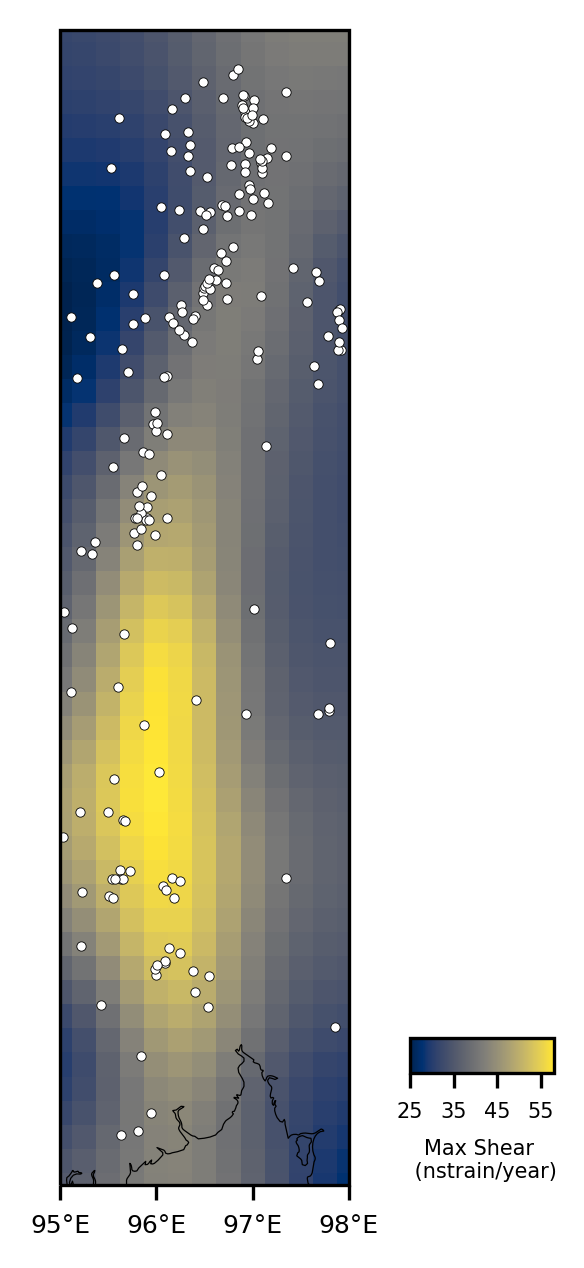

In [7]:
# Define the region of interest
min_lat_roi, max_lat_roi = 16, 28
min_lon_roi, max_lon_roi = 95, 98

##Set parameters for seismicity data
start_date = '1904-01-01'
end_date = '2022-12-31'

# Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
filtered_earthquake_locations_roi = earthquake_data[
    (earthquake_data['latitude'] >= min_lat_roi) &
    (earthquake_data['latitude'] <= max_lat_roi) &
    (earthquake_data['longitude'] >= min_lon_roi) &
    (earthquake_data['longitude'] <= max_lon_roi) &
    (earthquake_data['depth'] < depth)
]


# Create a finer grid for the strain rates
grid_size = 0.25  # Even finer grid resolution
lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)
lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

# Interpolate the strain rates onto the finer grid using cubic interpolation
points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
values = max_shear_strain.flatten()
interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='cubic')

# Optional: Apply stronger Gaussian smoothing to reduce artifacts
interpolated_strain_rates_smoothed = gaussian_filter(interpolated_strain_rates, sigma=2)

# Calculate the threshold for the top 65% strain rates
threshold_65_percent = np.percentile(interpolated_strain_rates_smoothed, 100 - 100)

# Mask the strain rates to show only the top 65%
masked_strain_rates = np.ma.masked_less(interpolated_strain_rates_smoothed, threshold_65_percent)

# Create the plot with Cartopy
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())

# Add the ocean feature with light blue color
ocean = cfeature.OCEAN
ax.add_feature(ocean, facecolor='lightblue')

# Add the land feature with wheat color
land = cfeature.LAND
ax.add_feature(land, facecolor='lightgrey')

ax.coastlines(resolution='10m', color='black', linewidth=0.3)
# Add gridlines with labels
# gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
# Set the latitude and longitude ticks, starting from 16°N and 90°E
ax.set_xticks([95, 96, 97, 98], crs=ccrs.PlateCarree())  # Longitude ticks
# ax.set_yticks([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], crs=ccrs.PlateCarree())  # Latitude ticks

# Change the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=6)

# Format longitude and latitude ticks with degree symbol
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°'))

# gl.top_labels = False
# gl.right_labels = False
# gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
# gl.ylabel_style = {'size': 7, 'color': 'black'}

# Define the colormap and normalize it for the strain rates
cmap = cm.cividis
norm = mcolors.Normalize(vmin=threshold_65_percent, vmax=np.max(interpolated_strain_rates_smoothed))

# Plot the top 65% strain rates using pcolormesh
img = ax.pcolormesh(lon_grid, lat_grid, masked_strain_rates, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Add an inset axis for the colorbar with precise width, height, and location
cax = inset_axes(ax, width="50%", height="3%", loc='lower right', borderpad=2,
                 bbox_to_anchor=(1, 0.025, 1, 1), bbox_transform=ax.transAxes)

# Add a colorbar for the strain rates
cbar = plt.colorbar(img, cax=cax, orientation='horizontal')

fontsize = 5
cbar.set_label('Max Shear \n (nstrain/year)', fontsize=fontsize, ha='center')
# # Set specific ticks on the colorbar
cbar.set_ticks([25, 35, 45, 55])  # Add ticks at 50, 100, and 150
cbar.ax.tick_params(labelsize=fontsize)

# Overlay the fault lines
# fault_data.plot(ax=ax, color='tab:red', linewidth=0.5, label='Faults', transform=ccrs.PlateCarree())

# overlat Sagaing fault data
start_idx = 0

# Plot each segment
for break_idx in segment_breaks:
    plt.plot(sagaing_fault['LON'].iloc[start_idx:break_idx], 
             sagaing_fault['LAT'].iloc[start_idx:break_idx], 
             color='k', linewidth=0.5)
    start_idx = break_idx

# Plot the last segment
plt.plot(sagaing_fault['LON'].iloc[start_idx:], sagaing_fault['LAT'].iloc[start_idx:], color='k', linewidth=0.5)


ax.scatter(filtered_earthquake_locations_roi['longitude'], filtered_earthquake_locations_roi['latitude'], 
            c='white', marker='o', s=5, edgecolor='k', linewidth=0.2,
                label='Seismicity (< 40 km)', transform=ccrs.PlateCarree(), zorder=2)


# # Save the figure to an 'output' folder
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'strain_map.png'), bbox_inches='tight')

# Show the plot
plt.show()

## Top 65% strain rate with all seismicity (including region outside 65%)

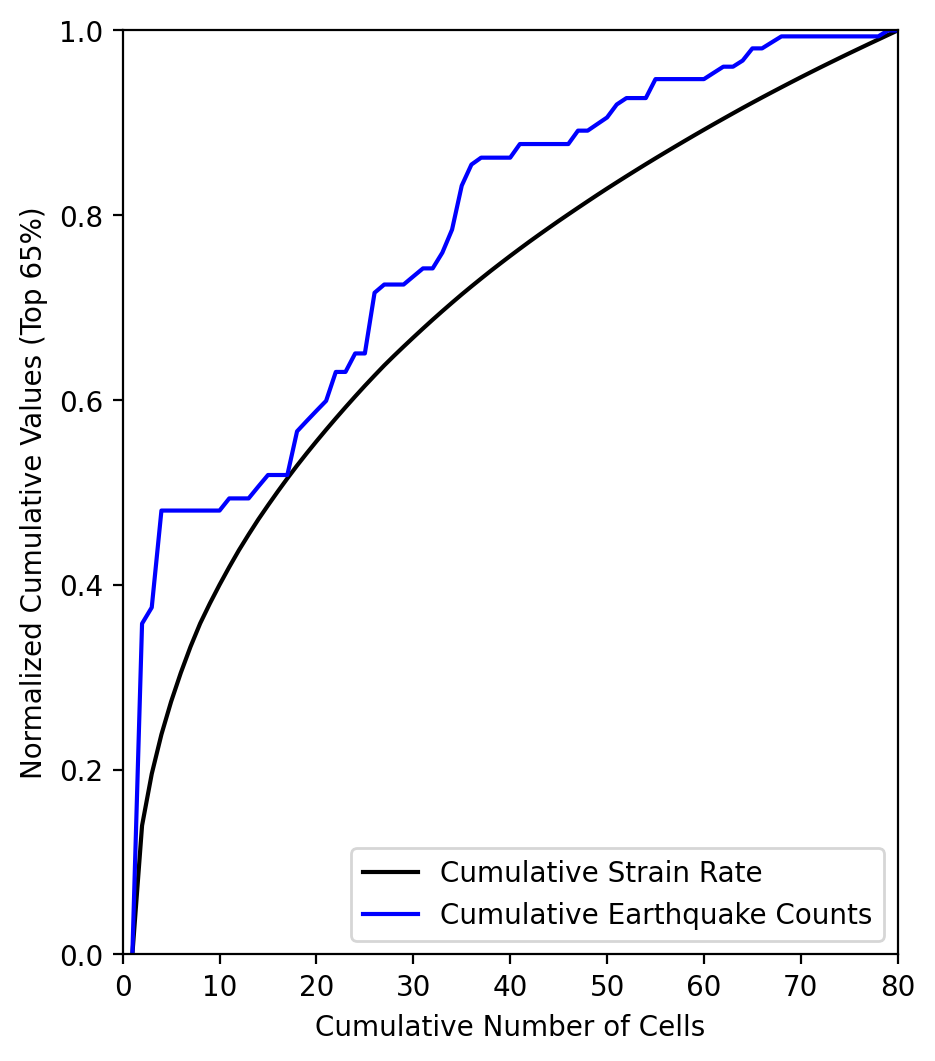

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

# Function to calculate and plot cumulative potency and earthquake counts
def plot_cumulative_potency_and_earthquake_counts(grid_size):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the strain rates to keep only the top 65%
    top_65_percent_index = int(0.65 * len(sorted_strain_rates))
    sorted_strain_rates = sorted_strain_rates[:top_65_percent_index]
    sorted_indices = sorted_indices[:top_65_percent_index]

#Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['depth'] < depth)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Flatten the earthquake count grid
    flattened_earthquake_counts = earthquake_count_grid.flatten()

    # Ensure the lengths of the arrays match
    min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
    sorted_indices = sorted_indices[:min_length]
    sorted_strain_rates = sorted_strain_rates[:min_length]
    flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

    # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
    valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]
    sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
    sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Filter out zero strain rates
    non_zero_strain_rates = sorted_strain_rates[sorted_strain_rates > 0]

    # Calculate the cumulative geodetic potency rate and normalize using power transformation
    cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
    cumulative_potency_rate = np.insert(cumulative_potency_rate, 0, 0)  # Ensure starting at 0
    power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)
    normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]

    # Calculate cumulative earthquake counts and normalize using power transformation
    cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
    cumulative_earthquake_counts = np.insert(cumulative_earthquake_counts, 0, 0)  # Ensure starting at 0
    power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)
    normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(5, 6), dpi=200)

    # Plot the normalized cumulative potency rate in black
    ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Strain Rate')

    # Plot the normalized cumulative earthquake counts in blue
    ax.plot(range(1, len(normalized_cumulative_earthquake_counts) + 1), normalized_cumulative_earthquake_counts, color='blue', label='Cumulative Earthquake Counts')

    # Customize plot
    ax.set_xlabel('Cumulative Number of Cells')
    ax.set_ylabel('Normalized Cumulative Values (Top 65%)')
    ax.set_xlim(0, len(normalized_cumulative_potency_rate))
    ax.set_ylim(0, 1)

    # Calculate indices for 10%, 25%, and 50% of the cumulative number of cells
    ten_percent_index = int(0.1 * len(normalized_cumulative_potency_rate))
    twenty_five_percent_index = int(0.4 * len(normalized_cumulative_potency_rate))
    fifty_percent_index = int(0.7 * len(normalized_cumulative_potency_rate))

#     # Add vertical lines at 10%, 25%, and 50%
#     ax.axvline(x=ten_percent_index, color='blue', linestyle='--', label='Top 10%')
#     ax.axvline(x=twenty_five_percent_index, color='green', linestyle='--', label='Top 40%')
#     ax.axvline(x=fifty_percent_index, color='red', linestyle='--', label='Top 70%')

    # Add a legend
    ax.legend(loc='lower right')
    
    # # Save the figure to an 'output' folder
#     output_dir = 'output'
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     plt.savefig(os.path.join(output_dir, 'correlation_1998-2018.png'), bbox_inches='tight')

    # Display the plot
    plt.show()

# Define the grid size to test
grid_size = 0.5  # Example grid size

# Call the function to plot the data
plot_cumulative_potency_and_earthquake_counts(grid_size)

# plt.show()

## Top 65% strain rate with seismicity inside this 65% region

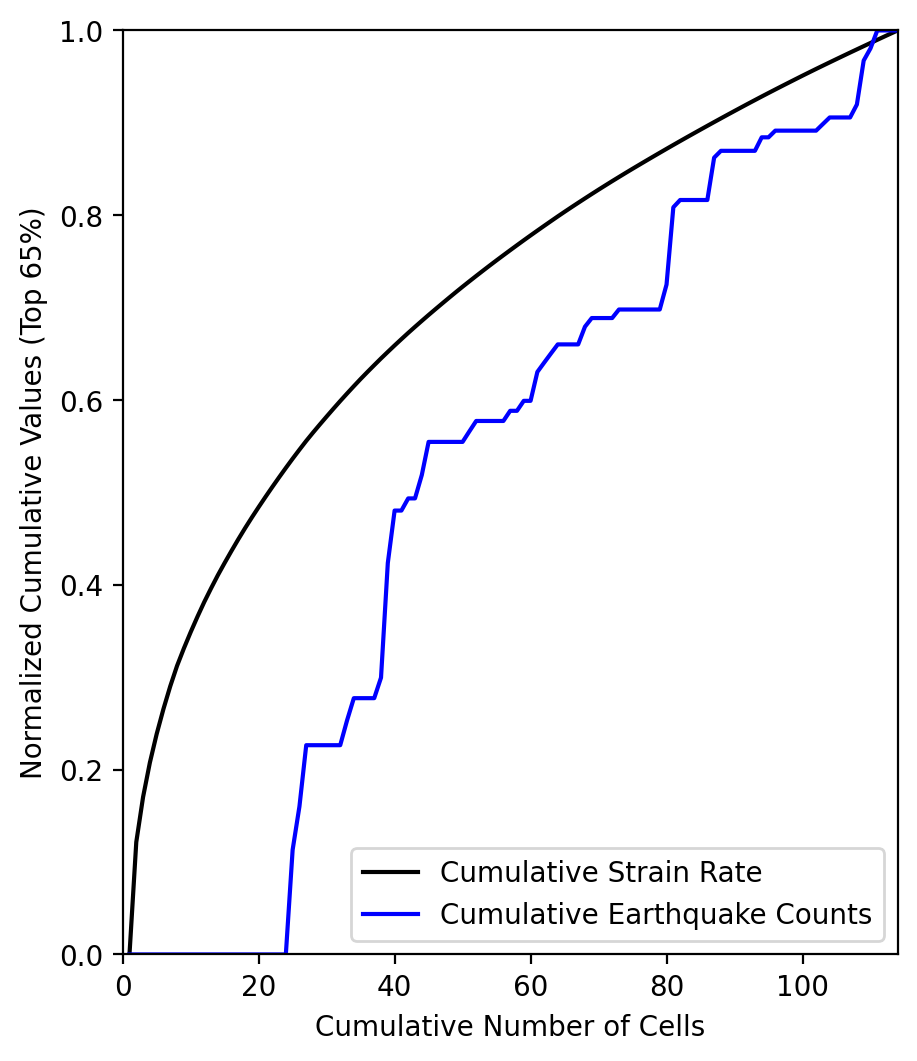

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

# Function to calculate and plot cumulative potency and earthquake counts
def plot_cumulative_potency_and_earthquake_counts(grid_size):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the strain rates to keep only the top 65%
    top_65_percent_index = int(0.65 * len(sorted_strain_rates))
    top_65_strain_rates = sorted_strain_rates[:top_65_percent_index]
    top_65_indices = sorted_indices[:top_65_percent_index]

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['depth'] < depth)
    ]

    # Create an empty grid for earthquake counts within the top 65% strain rate area
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell within the top 65% strain rate area
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            # Check if the grid cell is within the top 65% strain rate area
            if (x_idx + y_idx * (len(lon_bins) - 1)) in top_65_indices:
                earthquake_count_grid[y_idx, x_idx] += 1

    # Flatten the earthquake count grid
    flattened_earthquake_counts = earthquake_count_grid.flatten()

    # Ensure the lengths of the arrays match
    min_length = min(len(top_65_indices), len(top_65_strain_rates), len(flattened_earthquake_counts))
    valid_indices = top_65_indices[:min_length]
    valid_strain_rates = top_65_strain_rates[:min_length]
    valid_earthquake_counts = flattened_earthquake_counts[:min_length]

    # Handle NaN values in valid_strain_rates
    valid_strain_rates = np.nan_to_num(valid_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Filter out zero strain rates
    non_zero_strain_rates = valid_strain_rates[valid_strain_rates > 0]

    # Calculate the cumulative geodetic potency rate and normalize using power transformation
    cumulative_potency_rate = np.cumsum(non_zero_strain_rates * grid_cell_area)
    cumulative_potency_rate = np.insert(cumulative_potency_rate, 0, 0)  # Ensure starting at 0
    power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)
    normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]

    # Calculate cumulative earthquake counts and normalize using power transformation
    cumulative_earthquake_counts = np.cumsum(valid_earthquake_counts)
    cumulative_earthquake_counts = np.insert(cumulative_earthquake_counts, 0, 0)  # Ensure starting at 0
    power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)
    normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(5, 6), dpi=200)

    # Plot the normalized cumulative potency rate in black
    ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Strain Rate')

    # Plot the normalized cumulative earthquake counts in blue
    ax.plot(range(1, len(normalized_cumulative_earthquake_counts) + 1), normalized_cumulative_earthquake_counts, color='blue', label='Cumulative Earthquake Counts')

    # Customize plot
    ax.set_xlabel('Cumulative Number of Cells')
    ax.set_ylabel('Normalized Cumulative Values (Top 65%)')
    ax.set_xlim(0, len(normalized_cumulative_potency_rate))
    ax.set_ylim(0, 1)

    # Calculate indices for 10%, 25%, and 50% of the cumulative number of cells
    ten_percent_index = int(0.1 * len(normalized_cumulative_potency_rate))
    twenty_five_percent_index = int(0.4 * len(normalized_cumulative_potency_rate))
    fifty_percent_index = int(0.7 * len(normalized_cumulative_potency_rate))

    # Add a legend
    ax.legend(loc='lower right')
    
#     # # Save the figure to an 'output' folder
#     output_dir = 'output'
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     plt.savefig(os.path.join(output_dir, 'top65%_correlation_1998-2018.png'), bbox_inches='tight')

    # Display the plot
    plt.show()

# Define the grid size to test
grid_size = 0.5  # Example grid size

# Call the function to plot the data
plot_cumulative_potency_and_earthquake_counts(grid_size)

/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_4384/3568788738.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])


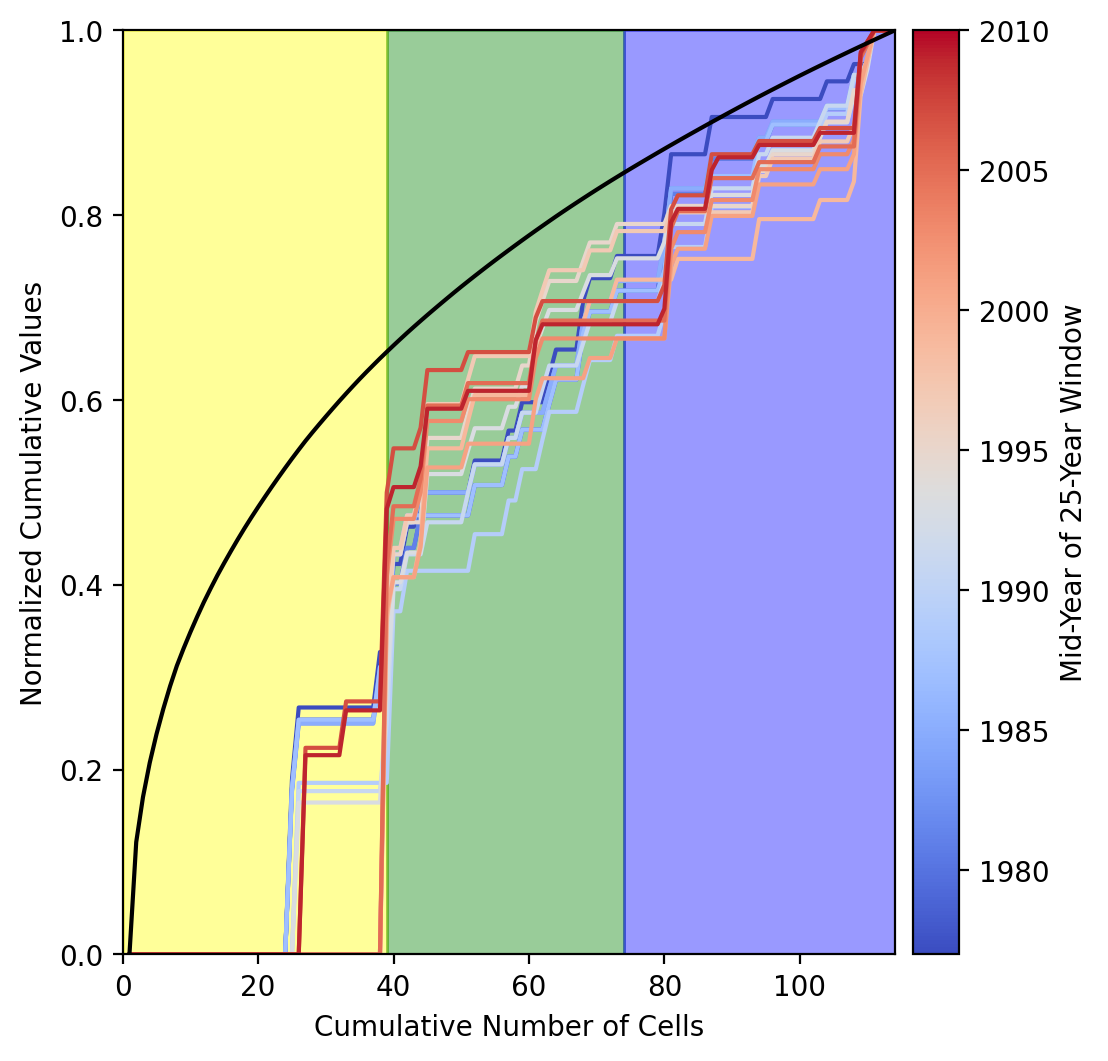

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
import pandas as pd
import os

# Function to calculate and plot cumulative potency and earthquake counts in moving windows
def plot_cumulative_potency_and_earthquake_counts(grid_size):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the strain rates to keep only the top 65%
    top_65_percent_index = int(0.65 * len(sorted_strain_rates))
    top_65_strain_rates = sorted_strain_rates[:top_65_percent_index]
    top_65_indices = sorted_indices[:top_65_percent_index]

    # Further divide the top 65% into 35%, 35-65%, and 65-100%
    top_35_percent_index = int(0.35 * len(top_65_strain_rates))
    top_35_strain_rates = top_65_strain_rates[:top_35_percent_index]
    mid_30_strain_rates = top_65_strain_rates[top_35_percent_index:top_65_percent_index]

    # Convert the earthquake date to datetime
    earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])

    # Define the time window parameters
    window_size = 25  # 25-year window
    step_size = 2  # 2-year step
    start_year = 1965
    end_year = 2022

    # Create a colormap for the different time windows
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=start_year + window_size // 2, vmax=end_year - window_size // 2)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

    # Loop over the time windows and calculate the cumulative earthquake counts
    for start in range(start_year, end_year - window_size + 1, step_size):
        end = start + window_size
        mid_year = start + window_size // 2

        # Filter the earthquake data for the current time window
        window_data = earthquake_data[
            (earthquake_data['date'] >= pd.to_datetime(f'{start}-01-01')) &
            (earthquake_data['date'] < pd.to_datetime(f'{end}-01-01'))
        ]

        # Filter the earthquake data for the region of interest, completeness magnitude, and depth
        filtered_earthquake_locations_roi = window_data[
            (window_data['latitude'] >= min_lat_roi) &
            (window_data['latitude'] <= max_lat_roi) &
            (window_data['longitude'] >= min_lon_roi) &
            (window_data['longitude'] <= max_lon_roi) &
            (window_data['magnitude'] >= 4.5) &
            (window_data['date'] >= start_date) &
            (window_data['date'] <= end_date) &
            (window_data['depth'] < depth)
        ]

        # Create an empty grid for earthquake counts within the top 65% strain rate area
        earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

        # Digitize the filtered earthquake locations into the grid
        x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
        y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

        # Increment the earthquake count for each grid cell within the top 65% strain rate area
        for x_idx, y_idx in zip(x_indices, y_indices):
            if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
                # Check if the grid cell is within the top 65% strain rate area
                if (x_idx + y_idx * (len(lon_bins) - 1)) in top_65_indices:
                    earthquake_count_grid[y_idx, x_idx] += 1

        # Flatten the earthquake count grid
        flattened_earthquake_counts = earthquake_count_grid.flatten()

        # Ensure the lengths of the arrays match
        min_length = min(len(top_65_indices), len(top_65_strain_rates), len(flattened_earthquake_counts))
        valid_indices = top_65_indices[:min_length]
        valid_strain_rates = top_65_strain_rates[:min_length]
        valid_earthquake_counts = flattened_earthquake_counts[:min_length]

        # Calculate cumulative earthquake counts and normalize using power transformation
        cumulative_earthquake_counts = np.cumsum(valid_earthquake_counts)
        cumulative_earthquake_counts = np.insert(cumulative_earthquake_counts, 0, 0)  # Ensure starting at 0
        power_cumulative_earthquake_counts = np.power(cumulative_earthquake_counts, 0.5)
        normalized_cumulative_earthquake_counts = power_cumulative_earthquake_counts / power_cumulative_earthquake_counts[-1]

        # Plot the normalized cumulative earthquake counts in color for the current window
        ax.plot(range(1, len(normalized_cumulative_earthquake_counts) + 1), normalized_cumulative_earthquake_counts,
                color=cmap(norm(mid_year)), label=f'{start}-{end}')

    # Plot the normalized cumulative potency rate in black
    cumulative_potency_rate = np.cumsum(top_65_strain_rates * (111.32 * grid_size)**2)
    cumulative_potency_rate = np.insert(cumulative_potency_rate, 0, 0)  # Ensure starting at 0
    power_cumulative_potency_rate = np.power(cumulative_potency_rate, 0.5)
    normalized_cumulative_potency_rate = power_cumulative_potency_rate / power_cumulative_potency_rate[-1]
    ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Strain Rate')
    
     # Add vertical lines at the top 50% and 70%
    fifty_percent_index = int(0.35 * len(normalized_cumulative_potency_rate))
    seventy_percent_index = int(0.65 * len(normalized_cumulative_potency_rate))
#     ax.axvline(x=fifty_percent_index, color='k', linestyle='--')
#     ax.axvline(x=seventy_percent_index, color='k', linestyle='--')
    
    alpha = 0.4
    # Highlight regions A (top 35%), B (35-65%), and C (65-100%)
    ax.fill_betweenx(y=np.arange(0, 1.1, 0.1), x1=0, x2=fifty_percent_index, color='yellow', alpha=alpha)
    ax.fill_betweenx(y=np.arange(0, 1.1, 0.1), x1=fifty_percent_index, x2=seventy_percent_index, color='green', alpha=alpha)
    ax.fill_betweenx(y=np.arange(0, 1.1, 0.1), x1=seventy_percent_index, x2=len(normalized_cumulative_potency_rate), color='blue', alpha=alpha)

    
    # Customize plot
    ax.set_xlabel('Cumulative Number of Cells')
    ax.set_ylabel('Normalized Cumulative Values')
    ax.set_xlim(0, len(normalized_cumulative_potency_rate))
    ax.set_ylim(0, 1)

    # Add a colorbar for the time windows
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Mid-Year of 25-Year Window')

    # Add a legend
#     ax.legend(loc='lower right')

#     # Save the figure to an 'output' folder
#     output_dir = 'output'
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     plt.savefig(os.path.join(output_dir, '0color_coded_correlation_1965-2022_top_65.png'), bbox_inches='tight')

    # Display the plot
    plt.show()

# Define the grid size to test
grid_size = 0.5  # Example grid size

# Call the function to plot the data
plot_cumulative_potency_and_earthquake_counts(grid_size)

/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


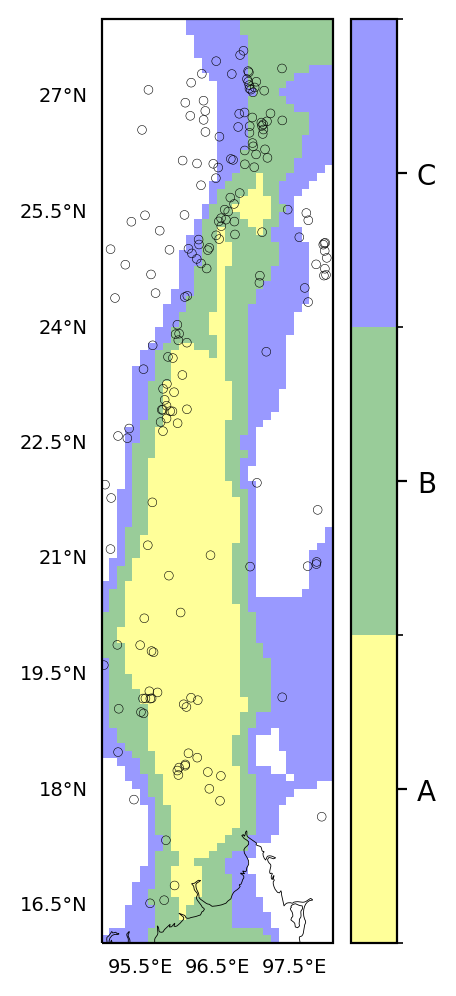

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import os
import pandas as pd

# Assuming max_shear_strain, latitudes, longitudes, and earthquake_data are already defined
# Define the region of interest (replace these with your specific values)
min_lat_roi, max_lat_roi = 16, 28
min_lon_roi, max_lon_roi = 95, 98
grid_size = 0.1  # Example grid size

# Define grid size and calculate lat/lon bins
lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

# Create a meshgrid for the region of interest
lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

# Interpolate the strain rates onto the grid
points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
values = max_shear_strain.flatten()
interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

# Flatten the interpolated strain rates and sort them
flattened_strain_rates = interpolated_strain_rates.flatten()
sorted_indices = np.argsort(flattened_strain_rates)[::-1]

# Filter out the top 65% of the strain rates
top_65_percent_index = int(0.65 * len(sorted_indices))
top_65_indices = sorted_indices[:top_65_percent_index]

# Further filter the top 65% into 50%, 50-70%, and 70-100%
top_50_percent_index = int(0.35 * len(top_65_indices))
top_70_percent_index = int(0.65 * len(top_65_indices))

# Create masks for different strain rate ranges within the top 65%
top_50_mask = np.zeros_like(flattened_strain_rates, dtype=bool)
mask_50_70 = np.zeros_like(flattened_strain_rates, dtype=bool)
mask_70_100 = np.zeros_like(flattened_strain_rates, dtype=bool)

top_50_mask[top_65_indices[:top_50_percent_index]] = True
mask_50_70[top_65_indices[top_50_percent_index:top_70_percent_index]] = True
mask_70_100[top_65_indices[top_70_percent_index:]] = True

# Reshape the masks to match the grid
top_50_mask_grid = top_50_mask.reshape(interpolated_strain_rates.shape)
mask_50_70_grid = mask_50_70.reshape(interpolated_strain_rates.shape)
mask_70_100_grid = mask_70_100.reshape(interpolated_strain_rates.shape)

# Filter seismicity data with depth < 30 km and magnitude > 4.0
filtered_seismicity = earthquake_data[
    (earthquake_data['latitude'] >= min_lat_roi) &
    (earthquake_data['latitude'] <= max_lat_roi) &
    (earthquake_data['longitude'] >= min_lon_roi) &
    (earthquake_data['longitude'] <= max_lon_roi) &
    (earthquake_data['date'] >= start_date) &
    (earthquake_data['date'] <= end_date) &
    (earthquake_data['magnitude'] >= 4.5) &
    (earthquake_data['depth'] < depth)
]

filtered_lons = filtered_seismicity['longitude']
filtered_lats = filtered_seismicity['latitude']

# Plot using Cartopy
fig, ax = plt.subplots(figsize=(6, 6), dpi=200, subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.coastlines(resolution='10m', color='black', linewidth=0.3)
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'size': 7, 'color': 'black'}

# Plot the grid cells with different colors
for i in range(lat_grid.shape[0] - 1):
    for j in range(lon_grid.shape[1] - 1):
        if top_50_mask_grid[i, j]:
            color = 'yellow'  # Yellow for top 50%
        elif mask_50_70_grid[i, j]:
            color = 'green'  # Green for 50-70%
        elif mask_70_100_grid[i, j]:
            color = 'blue'  # Blue for 70-100%
        else:
            color = 'white'  # Grey for the rest
        ax.add_patch(plt.Rectangle(
            (lon_grid[i, j], lat_grid[i, j]), grid_size, grid_size,
            edgecolor='none', facecolor=color, alpha=0.4, transform=ccrs.PlateCarree()))

# Overlay filtered seismicity as red open circles
ax.scatter(filtered_lons, filtered_lats, edgecolor='k', linewidth=0.2, facecolor='none', s=10, label='Seismicity (Depth < 30 km, M > 4.0)')

# Set extent and add gridlines
ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())

# Add a colorbar for the different strain rate colors
cmap = mcolors.ListedColormap(['yellow', 'green', 'blue'])
bounds = [0, 50, 70, 100]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.02, alpha=0.4)
cbar.set_ticks([25, 60, 85])
cbar.set_ticklabels(['A', 'B', 'C'])
# cbar.set_label('Strain Rate Percentile')

# # Save the figure to an 'output' folder
# output_dir = 'output'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# plt.savefig(os.path.join(output_dir, '3regions_strain_tops.png'), bbox_inches='tight')

# Show the plot
plt.show()